Download the PASCAL VOC dataset

In [ ]:
from torchvision.datasets import VOCSegmentation
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define dataset root
data_dir = './data'

# Initialize the VOCSegmentation dataset
voc_full = VOCSegmentation(
    root=data_dir,
    year='2012',
    image_set='trainval',
    download=False
)

On inspection of the pascal VOC data. We see that the label void (255) looks to be representative of edges. We will use this property in the creation of an estimated ground truth for edges. Here, we will map 255 to 1 for edges and other colors to 0.

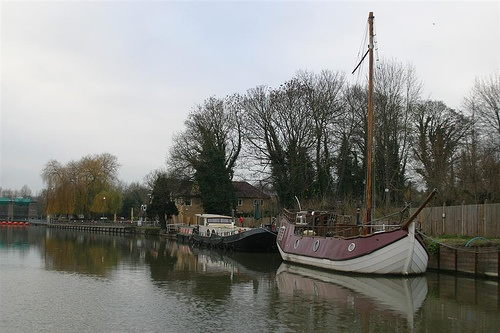

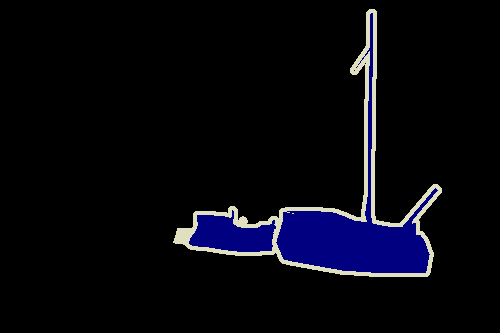

In [ ]:
boat = voc_full[4]

boat[0].show() # show the first image
boat[1].show() # show the first image

Now we try to get an edge map for this boat example. We convert the segmentation mask into a binary edge mask.

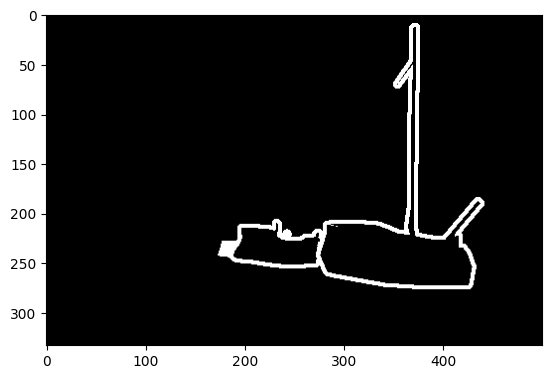

In [12]:
boat_mask = boat[1]

def get_edge_mask(segmentation_mask):
    """
    Converts a PASCAL VOC segmentation mask into a binary edge mask.
    Parameters:
        segmentation_mask: A PIL image object representing the segmentation mask
    Returns:
        A numpy array where the edges are marked as 1 and everything else is 0
    """
    # Convert PIL image to numpy array
    segmentation_mask_arr = np.asarray(segmentation_mask)
    # Generate edge mask
    edge_mask = (segmentation_mask_arr == 255).astype(np.uint8)
    return edge_mask


edge_mask = get_edge_mask(boat_mask)
plt.imshow(edge_mask, cmap='gray')

Create a custom 70/30 split between training and evaluation data for training the neural network later.

In [46]:
from sklearn.model_selection import train_test_split

# Split into 70% train and 30% eval
train_dataset, eval_dataset = train_test_split(
    voc_full,
    test_size=0.3,
    random_state=1
)

print(f"Training samples: {len(train_dataset)}")
print(f"Evaluation samples: {len(eval_dataset)}")

Training samples: 2039
Evaluation samples: 874


Wrap the data in a dataset

In [47]:
from torch.utils.data import DataLoader, Dataset

class VOCWithEdgeMask(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.edge_masks = [get_edge_mask(data[1]) for data in dataset]
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        edge_mask = self.edge_masks[idx]
        return img, label, edge_mask


# Wrap datasets
train_dataset = VOCWithEdgeMask(train_dataset)
eval_dataset = VOCWithEdgeMask(eval_dataset)

Initialize Dataloaders for training the neural network

In [45]:
import os

num_workers = os.cpu_count() if os.cpu_count() is not None else 4

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=num_workers,
    pin_memory= True
)

eval_loader = DataLoader(
    eval_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)